In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys 
sys.path.append('..')
from renderer import render

In [2]:
np.set_printoptions(suppress=True)
TIME_COLUMN_INDEX = 0
OPEN_COLUMN_INDEX = 1
CLOSE_COLUMN_INDEX = 4
VOLUME_COLUMN_INDEX = 5
EPISODE_SIZE = 10000
WINDOW_SIZE = 1200
LOOK_AHEAD = 15
TRAIN_SPLIT = 0.85

In [3]:
def read_data(filename="../data/bitfinex-BTCUSD-1m.csv", date_columns="DateTime"):
    df = pd.read_csv(filename, parse_dates=[date_columns])
    df = df[~np.isnan(df['Close'])].set_index(pd.DatetimeIndex(df[date_columns]))
    df['Volume'] = ((df['Volume'] - df['Volume'].mean())/df['Volume'].std())
    return df

def normalize_episode(df_episode):
    df_episode_norm = df_episode.copy()
    df_episode_norm['Open']  = df_episode_norm['Open'] / df_episode.iloc[0]['Open']
    df_episode_norm['High']  = df_episode_norm['High'] / df_episode.iloc[0]['Open']
    df_episode_norm['Low']   = df_episode_norm['Low']  / df_episode.iloc[0]['Open']
    df_episode_norm['Close'] = df_episode_norm['Close']/df_episode.iloc[0]['Open']
    return df_episode_norm

def get_train_test_sets(df, train_split):
    state_len = df.shape[0]
    train_end_index = int(train_split * state_len)
    train_state = df[0:train_end_index]
    test_state = df[train_end_index:]
    print("Train state: ", train_state.shape, "test state: ", test_state.shape, "total:", state_len)
    return train_state, test_state

def get_state_window_count(state, window_size, look_ahead):
    return state.shape[0] - window_size - look_ahead + 1

def get_features_number(df):
    return df.shape[1] - 1

def get_y_label(episode_data, look_ahead, smooth=True, normalize=True):
    regular_close = episode_data['Close']
    shifted_close = episode_data.shift(-look_ahead)['Close']
    diff = (shifted_close - regular_close).dropna()
    if normalize:
        diff = diff / diff.std()
    if smooth:
        diff = savgol_filter(diff, 9, 3)
    y_category = ((np.sign(diff) + 1) / 2).astype(int)
    return diff, y_category

def get_episode_data(state, start_index, episode_size, look_ahead):
    episode_state = state[start_index : start_index + episode_size].copy()
    X_episode = np.array(normalize_episode(episode_state))[:-look_ahead,:]
    Y_diff, Y_category = get_y_label(episode_state, look_ahead)
    return X_episode, np.array(Y_diff), np.array(Y_category)

In [4]:
df = read_data()
train_state, test_state = get_train_test_sets(df, TRAIN_SPLIT)
features_number = get_features_number(df)
train_length = get_state_window_count(train_state, WINDOW_SIZE, LOOK_AHEAD)
test_length = get_state_window_count(test_state, WINDOW_SIZE, LOOK_AHEAD)
train_length, test_length, features_number

Train state:  (686800, 6) test state:  (121200, 6) total: 808000


(685586, 119986, 5)

In [5]:
X_episode, Y_diff, Y_category = get_episode_data(train_state, start_index=675000, episode_size=EPISODE_SIZE, look_ahead=LOOK_AHEAD)
print(X_episode[0:2], Y_diff[0:2], X_episode.shape, Y_diff.shape)

[[Timestamp('2018-01-09 13:31:00') 1.0 1.0026845255787675
  0.9999928476810821 1.0019253343768562 -0.14518293921277012]
 [Timestamp('2018-01-09 13:32:00') 1.0019253343768562 1.0032366646347028
  0.9993716912431547 0.9995097260071386 0.8170516479262113]] [-2.14767894 -2.18036576] (9985, 6) (9985,)


/Users/philips/.virtualenvs/cv3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
def render_X(X_set, start=0, end=500):
    values = X_set[start:end].copy().T
    trades = np.zeros((2, values.shape[1]))
    trade_values = np.concatenate((values, trades), axis=0)
    print(trade_values.T.shape)
    render(trade_values.T, title="X", scale=1)

def render_y(y, start=0, end=500):
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(y[start:end])
    plt.show()

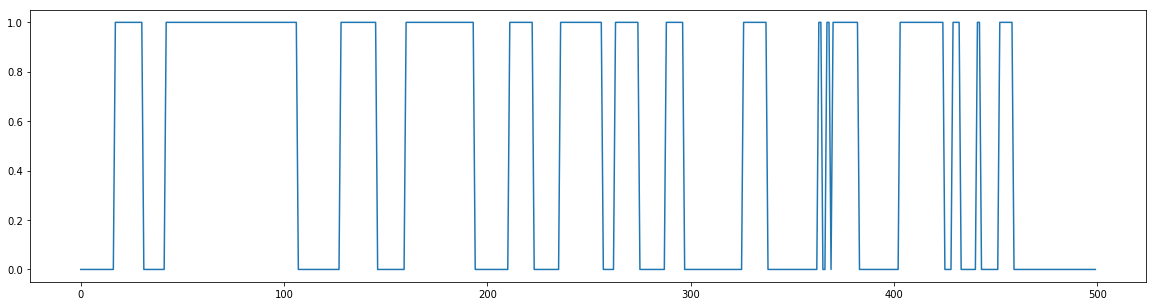

In [7]:
render_y(Y_category)

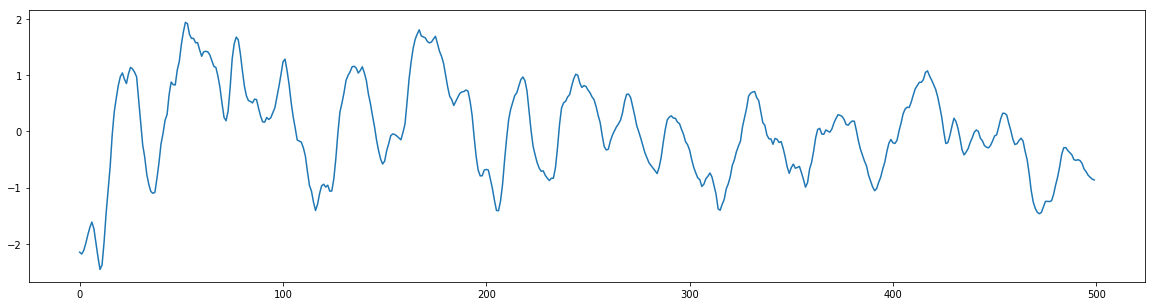

In [8]:
render_y(Y_diff)

(500, 8)


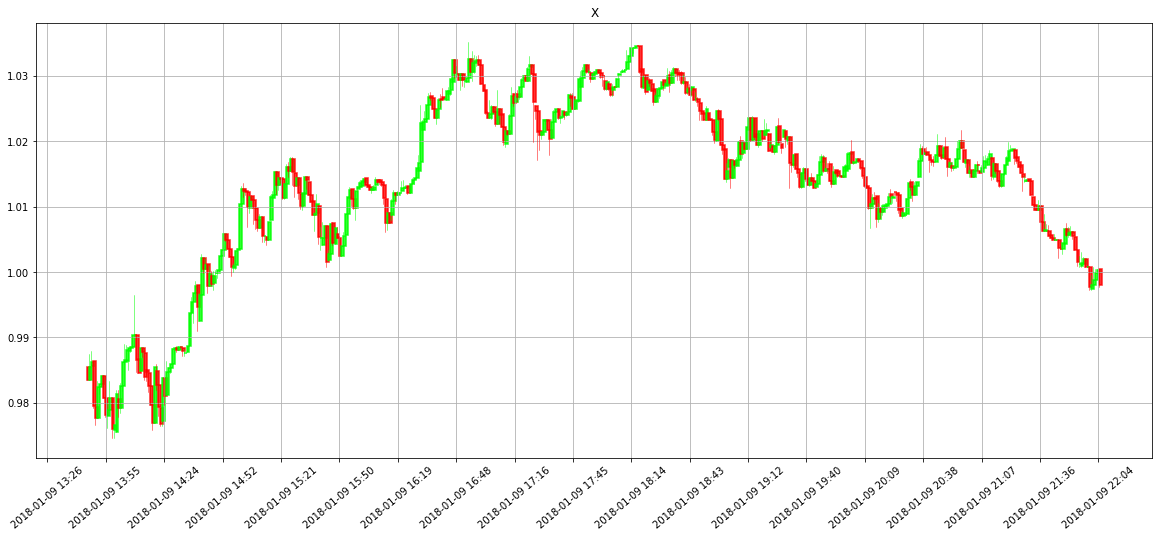

In [9]:
render_X(X_episode, start=15, end=515)